# 1. Set up

### Download the data

In [ ]:
#Download data in the data folder
from azureml.core import Workspace, Dataset

subscription_id = '78b4d5f1-fca5-4af5-b686-34747c61c20f'
resource_group = 'ressource-group-Changins'
workspace_name = 'workspace-changins'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='oilseed-rape-dataset')
dataset.download(target_path='../../data/oilseed_rape', overwrite=True)

### General imports

In [1]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms as T
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from utils import plotImgs, TrainingDataset, InferenceDataset, Inference
from utils import my_confusion_matrix, cm2rates, rates2metrics

# 2. Data exploration

Before starting a model, it's always good have an overview of the data we work with. Especially, the class balance will be impacting the results. 

In [3]:
# Load images and masks
root = os.getcwd()
img_dir = root + '/../../data/oilseed_rape/train/Images'
img_paths = glob(img_dir + '/*')
mask_dir = root + '/../../data/oilseed_rape/train/Masks'
mask_paths = glob(mask_dir + '/*')

In [ ]:
img = cv2.cvtColor(cv2.imread(img_paths[1]), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(mask_paths[1]), cv2.COLOR_BGR2RGB)

print('Data type:', type(img))
print('')
print('Data size')
print('Mask ([ H, W, C]):', mask.shape)
print('Image ([H, W, C]):', img.shape)
print('')
print('Mask \n', mask[:4,:4])
print('')
print('Image \n', img[:4,:4])

In [ ]:
# A simple way to plot images
"""
plt.imshow(img)
plt.show()
""" 

# Nice plots
plotImgs(1, 2, [img, mask], ['Image','Mask'])

In [ ]:
new_val = np.zeros((len(mask_paths),3))

for i, p in enumerate(mask_paths):
    mask = cv2.imread(p)
    #Create 3 classes, 0:BG, 1:SP, 2:OSR
    new_mask = np.zeros(mask.shape)
    new_mask[mask > 127] = 1              
    new_mask[new_mask[:, :, 1] > 0, 2] = 2
    class_mask = new_mask[:, :, 2].astype(int)

    # Get distribution per images

    size = class_mask.shape[0]*class_mask.shape[1]
    result = np.unique(class_mask, return_counts=True )
    new_val[i,result[0]] += np.round(100*result[1]/size,2)

In [ ]:
df = pd.DataFrame(new_val, columns = ['Background', 'Other plants', 'Oilseed rape'])
df.head()

In [ ]:
colors = ['dimgrey','r','gold']
sns.set(rc={"figure.figsize":(5,3)}) 
sns.boxplot( data=df, palette = colors)
plt.show()

In [ ]:
df.plot.bar(subplots = True, figsize=(9, 8), color=colors,  sharey=True, title = 'Class distribution of the tranining images')
plt.show()

# Stream data

In [5]:
class DatasetInfo:
    """ Class used to define all parameters and methods specific to the data sources (inputs and targets) """

    def __init__(self):

        # Get methods and parameters corresponding to input and target sources
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # parameterize the output(s)
        self.n_classes = 3
        self.class_names = ['BG', 'SP', 'OSR']

        # set patch parameters for inference
        self.num_patches_per_tile = 4 
        self.patch_size = 320 #256 min value size for windows using pretrained DeepLabv3+
        self.padding = 80
        self.stride = self.patch_size -  self.padding

        # Initialize the dictionnary of logs
        self.dict_metrics = ['acc', 'prec', 'recall', 'f1', 'sup'] #add iou
        self.dict_attribute = self.class_names + ['Mean', 'FW']
        cols = []
        
        for a in self.dict_attribute:
            for m in self.dict_metrics:
                title = a + '_' + m
                cols.append(title)
        
        self.columns = ['Filename', 'Cov', 'Pred'] + cols
            
        

    ################# Methods for pre/post-processing ######################### 
    
    def preprocess_input(self, inputs):
        #normalize image and convert to tensor
        transforms = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
        ])        
        return transforms(inputs)
    
    def preprocess_target(self, targets):
        
        #Create 3 classes, 0:BG, 1:SP, 2:OSR
        mask = np.zeros(targets.shape)
        mask[targets > 127] = 1              
        mask[mask[:, :, 1] > 0, 2] = 2
        
        return torch.from_numpy(mask[:, :, 2].astype(np.int64))
    
    def rescale(self, img):
        
        dim = (int(img.shape[1]//2), int(img.shape[0]//2))
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        
        return resized

    def create_kernel(self):
        k = np.ones((self.patch_size, self.patch_size), dtype=np.float32)
        k[self.padding//2:-self.padding//2, self.padding//2:-self.padding//2] = 5
        return k

    def get_inference_kernel(self):
        kernel = self.create_kernel()
        return kernel

In [6]:
debug = True
batch_size = 4
num_epochs = 10
n_workers = 6

output_dir = root + '/output' 
input_dir = root + '/../../data/oilseed_rape' 
exp_name = os.path.basename(output_dir)
log_fn = os.path.join(output_dir, '{}_metrics.pt'.format(exp_name))
model_fn = os.path.join(output_dir, '{}_model.pt'.format(exp_name))

# Create metrics dictionnary to save logs of the training
save_dict = {    
    'model_checkpoints': [],
    'optimizer_checkpoints' : [],
    'train_losses': [],
    'train_reports':[],
    'val_losses':[],
    'val_reports' : [],
    'epochs' : []
    }

ds_info = DatasetInfo()

In [8]:
fn_val = [f[0] for f in pd.read_csv(root + '/dataset/validation_dataset.csv').values]
input_fns, target_fns = np.array(glob(input_dir + '/train/Images/*')), np.array(glob(input_dir + '/train/Masks/*'))  
cond = [t.split('/')[-1].split('.')[0] in fn_val for t in target_fns]
    
input_fns_val, target_fns_val = input_fns[cond], target_fns[cond]
input_fns, target_fns = input_fns[np.invert(cond)], target_fns[np.invert(cond)]

# for debugging: use subset of training set
if debug:
    input_fns = input_fns[:10]
    target_fns = target_fns[:10]
    #input_fns_val, target_fns_val = input_fns_val[:3], target_fns_val[:3]

print('Length training dataset', len(input_fns))
print('Length validation dataset', len(input_fns_val))

In [9]:
dataset = TrainingDataset(
            input_fns = input_fns, 
            target_fns = target_fns, 
            dataset_info = ds_info,
            verbose=False
        )

# create dataloader
dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size = batch_size,
            num_workers = n_workers,
            pin_memory=True,
        )
print('Training dataloader created')

Length training dataset 10
Length validation dataset 5
Training dataloader created


In [11]:
data, target = next(iter(dataloader)) 

print('Data type:', type(data))
print('')
print('Data size')
print('Mask from dataloader ([N, H, W]):', target.shape)
print('Image from dataloader ([N, C, H, W]):', data.shape)
print('')
print('Mask from dataloader \n', target[0,:4,:4])

print('Image from dataloader \n', data[0,:,:4,:4])

Data type: <class 'torch.Tensor'>

Data size
Mask from dataloader ([N, H, W]): torch.Size([4, 320, 320])
Image from dataloader ([N, C, H, W]): torch.Size([4, 3, 320, 320])

Mask from dataloader 
 tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])
Image from dataloader 
 tensor([[[-1.6898, -1.7069, -1.5699, -1.4500],
         [-1.4843, -1.2959, -1.1760, -1.0733],
         [-1.0219, -1.0562, -1.0733, -1.0562],
         [-0.9877, -1.0733, -1.0733, -1.0390]],

        [[-1.5805, -1.6155, -1.5280, -1.3880],
         [-1.4405, -1.2479, -1.1604, -1.0553],
         [-1.0203, -1.0553, -1.0903, -1.0728],
         [-1.0028, -1.1078, -1.1078, -1.0728]],

        [[-1.5256, -1.5779, -1.4907, -1.3687],
         [-1.4384, -1.2816, -1.2119, -1.1073],
         [-1.0724, -1.1596, -1.1770, -1.1944],
         [-1.1247, -1.2467, -1.2467, -1.2119]]])


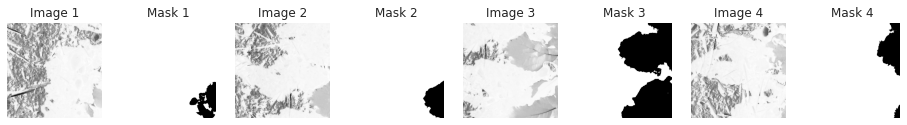

In [12]:
plotImgs(1,8,[data[0,0], target[0]*127, data[1,0], target[1]*127, data[2,0], target[2]*127, data[3,0], target[3]*127], 
    ['Image 1','Mask 1', 'Image 2','Mask 2', 'Image 3','Mask 3', 'Image 4','Mask 4'])

## Create the model

In [13]:
#Load pretrained model
model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)

#Auxiliaire classifier is modified according to number of class to predict
model.classifier = DeepLabHead(2048, ds_info.n_classes) #YOUR CODE HERE

In [14]:
torch.cuda.empty_cache()

# Set model architecture
# Create model and criterion, and forward + backward pass function
model = model.to(ds_info.device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [15]:
def fit(model, device, dataloader, optimizer, criterion, n_batches, dataset_info):
    """
    For the temporal model (1) Unet + GRU
    Runs 1 training epoch
    n_batches is used to setup the progress bar only. The actual number of batches is defined by the dataloader.
    """
    model.train()
    torch.cuda.empty_cache()

    losses = []
    running_loss = 0.0
    
    # train batch by batch
    progress_bar = tqdm(enumerate(dataloader), total=n_batches)
    #torch.cuda.set_device()
    cm_cum = np.zeros((dataset_info.n_classes,) * 2).astype('int64')

    for batch_idx, data in progress_bar:

        input, target = data[0], data[1]

        # train batch by batch
        target = target.to(device)
        input = input.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()

        result = model(input) #(N,C,H,W")
        loss = criterion(result['out'], target.long())

        losses.append(loss.item())
        running_loss += loss.item()
        loss.backward()

        output = torch.argmax(result['out'], axis = 1)

        cm_cum += my_confusion_matrix(target.long().cpu(), output.cpu(), dataset_info.n_classes)
        dict_cm = cm2rates(cm_cum)
        train_metrics = rates2metrics(dict_cm, dataset_info.class_names)
    
        optimizer.step() 

        # print running loss
        progress_bar.set_postfix(
            loss = np.mean(losses), 
            acc = train_metrics['mean']['accuracy'], 
            prec = train_metrics['mean']['precision'], 
            rec = train_metrics['mean']['recall'])
        running_loss = 0.0
        
    avg_loss = np.mean(losses)
    
    return avg_loss, train_metrics

In [16]:
n_batches_per_epoch = int(len(dataset.fns) * ds_info.num_patches_per_tile / batch_size)
infer = Inference(model, ds_info, output_dir)

In [17]:
for i, epoch in enumerate(range(0, num_epochs)):
    print('\nTraining epoch: {}'.format(epoch))
    
    # shuffle data at every epoch (placed here so that all the workers use the same permutation)
    np.random.shuffle(dataset.fns)

    # forward and backward pass
    avg_loss, metrics_train = fit(
                    model,
                    ds_info.device,
                    dataloader,
                    optimizer,
                    criterion,
                    n_batches_per_epoch,
                    ds_info
                )

    # evaluation (validation) 
    metrics_val, loss_val = infer._get_inference(input_fns_val, target_fns_val, criterion)


    # update and save dictionary containing metrics and checkpoints
    save_dict['val_reports'].append(metrics_val)
    save_dict['val_losses'].append(loss_val)
    save_dict['train_losses'].append(avg_loss)
    save_dict['train_reports'].append(metrics_train)
    save_dict['model_checkpoints'].append(model.state_dict())
    save_dict['optimizer_checkpoints'].append(optimizer.state_dict())
    save_dict['epochs'] = epoch + 1 # number of epochs already computed

    with open(log_fn, 'wb') as f:
        torch.save(save_dict, f)

    # save the last checkpoint in a separate file
    last_checkpoint = {'model': model.state_dict(),
                                    'optimizer': optimizer.state_dict(),
                                    'epoch': epoch,
                                    'model_params': {}} #TEMPORARY
    torch.save(last_checkpoint, model_fn)


Training epoch: 0

Training epoch: 1

Training epoch: 2

Training epoch: 3

Training epoch: 4

Training epoch: 5


  0%|          | 0/10 [00:00<?, ?it/s]/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/computer_vision_with_azure_course/2_semantic_segmentation/utils/eval_utils.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  y_pred = y_pred[ind]
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/computer_vision_with_azure_course/2_semantic_segmentation/utils/eval_utils.py:23: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  y_true = y_true[ind]
 80%|████████  | 4/5 [00:18<00:04,  4.53s/it]


KeyboardInterrupt: 